In [649]:
import stim
import numpy as np
import pymatching
import sinter

In [650]:
data_qubit_coords={(2,0):1,(2,2):2,(2,4):3,(4,4):4,(0,6):5,(2,6):6,(4,6):7,(4,0):8,(6,0):9, (4,2):10, (6,2):11}
ancilla_qubit_coords={(1,4):12, (3,2):13, (3, 5):14, (5,4):15, (5,1):16, (1,6):17, (2,3):18, (4,3):19, (3,0):20, (6,1):21, (1,4):22, (3,2):23, (3, 5):24, (5,4):25, (5,1):26, 27: (4, 1)}
color_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)}
color_face_X_stabilizer = {22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)}
edge_X_stabilizer = {17: (5,6), 18: (2,3), 19: (4,10), 20: (1,8)}
surface_face_X_stabilizer = {24: (3, 4, 6, 7), 26: (8, 9, 10, 11)}
surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 15: (4,7,10,11)}
surface_edge_Z_stabilizer = {21: (9,11)}
bell_state_stabilizer={27: (8,10)}

In [651]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# キュービットの座標とインデックスの定義
def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 5), 15: (5, 4), 16: (5, 1),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (1, 4), 23: (3, 2), 24: (3, 5), 25: (5, 4), 26: (5, 1), 27: (4, 1)
    }

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=True):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")
    
    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")
    
    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")
    
    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("MR", [ancilla])
    
    # DETECTORの追加
    if add_detector:
        for idx, ancilla in enumerate(stabilizer.keys()):
            circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx)])

# Bell状態の安定化子 (X stabilizer と Z⊗Z stabilizer) を追加
def append_bell_stabilizers(circuit, bell_state_stabilizer):
    for ancilla, data_qubits in bell_state_stabilizer.items():
        # X_8X_10 安定化子
        circuit.append("H", [ancilla])  # Hゲートで基底をXに変換
        circuit.append("TICK")
        circuit.append("CX", [ancilla, data_qubits[0]])  # CNOT
        circuit.append("TICK")
        circuit.append("CX", [ancilla, data_qubits[1]])
        circuit.append("TICK")
        circuit.append("H", [ancilla])  # 基底を元に戻す
        circuit.append("TICK")
        circuit.append("MR", [ancilla])  # 測定
        circuit.append("TICK")

        # Z_8Z_10 安定化子
        circuit.append("CX", [data_qubits[0], ancilla])  # CNOTで情報をエンコード
        circuit.append("TICK")
        circuit.append("CX", [data_qubits[1], ancilla])
        circuit.append("TICK")
        circuit.append("MR", [ancilla])  # 測定
        circuit.append("TICK")

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]  # データキュービットのリストを作成
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]  # アンシラキュービットのリストを作成

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)
    }
    edge_X_stabilizer = {
        17: (5, 6), 18: (2, 3), 19: (4, 10), 20: (1, 8)
    }
    surface_face_X_stabilizer = {
        24: (3, 4, 6, 7), 26: (8, 9, 10, 11)
    }
    surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4,8,10), 15: (4,7,10,11)}
    surface_edge_Z_stabilizer = {21: (9,11)}
    bell_state_stabilizer = {27: (8, 10)}  # Bell状態の安定化子の定義

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")
    append_syndrome_measurement(circuit, color_face_Z_stabilizer)
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True)

    # Bell状態の安定化子を追加

    append_bell_stabilizers(circuit, bell_state_stabilizer)
    circuit.append("M", [9, 11])

    append_syndrome_measurement(circuit, edge_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    append_syndrome_measurement(circuit, surface_face_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    circuit.append("TICK")
    # surface_face_X_stabilizer の測定の直前に H を追加

    circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-5)])
    circuit.append("DETECTOR", [stim.target_rec(-2)])
    circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-6)])

    append_syndrome_measurement(circuit, surface_face_Z_stabilizer, is_X_stabilizer=False, add_detector=True)
    append_syndrome_measurement(circuit, surface_edge_Z_stabilizer, is_X_stabilizer=False, add_detector=True)

    

    # 回路の表示
    print(circuit)


QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 5) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 1) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(1, 4) 22
QUBIT_COORDS(3, 2) 23
QUBIT_COORDS(3, 5) 24
QUBIT_COORDS(5, 4) 25
QUBIT_COORDS(5, 1) 26
QUBIT_COORDS(4, 1) 27
R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
TICK
CX 2 12 1 13 3 14
TICK
CX 3 12 2 13 4 14
TICK
CX 5 12 3 13 6 14
TICK
CX 6 12 4 13 7 14
TICK
MR 12 13 14
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
H 22 23 24
TICK
CX 22 2 23 1 24 3
TICK
CX 22 3 23 2 24 4
TICK
CX 22 5 23 3 24 6
TICK
CX 22 6 23 4 24 7
TICK
H 22 23 24
TICK
MR 22 23 24
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR re

In [652]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# キュービットの座標とインデックスの定義
def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 5), 15: (5, 4), 16: (5, 1),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1),
        22: (1, 4), 23: (3, 2), 24: (3, 5), 25: (5, 4), 26: (5, 1), 27: (4, 1)
    }

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append_operation("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append_operation("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append_operation("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=True):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append_operation("H", [ancilla])
        circuit.append_operation("TICK")
    
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append_operation("CX", [ancilla, data_qubit])
                else:
                    circuit.append_operation("CX", [data_qubit, ancilla])
        circuit.append_operation("TICK")
    
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append_operation("H", [ancilla])
        circuit.append_operation("TICK")
    
    for ancilla in stabilizer.keys():
        circuit.append_operation("MR", [ancilla])
    
    if add_detector:
        for idx, ancilla in enumerate(stabilizer.keys()):
            circuit.append_operation("DETECTOR", [stim.target_rec(-len(stabilizer) + idx)])

# Bell状態の安定化子 (X stabilizer と Z⊗Z stabilizer) を追加
def append_bell_stabilizers(circuit, bell_state_stabilizer):
    for ancilla, data_qubits in bell_state_stabilizer.items():
        circuit.append_operation("H", [ancilla])  # X基底に変換
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [ancilla, data_qubits[0]])
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [ancilla, data_qubits[1]])
        circuit.append_operation("TICK")
        circuit.append_operation("H", [ancilla])  # 基底を元に戻す
        circuit.append_operation("TICK")
        circuit.append_operation("MR", [ancilla])  # 測定
        circuit.append_operation("TICK")

        circuit.append_operation("CX", [data_qubits[0], ancilla])  # Z⊗Z 安定化子
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [data_qubits[1], ancilla])
        circuit.append_operation("TICK")
        circuit.append_operation("MR", [ancilla])  # 測定
        circuit.append_operation("TICK")

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        22: (2, 3, 5, 6), 23: (1, 2, 3, 4), 24: (3, 4, 6, 7)
    }
    edge_X_stabilizer = {
        17: (5, 6), 18: (2, 3), 19: (4, 10), 20: (1, 8)
    }
    surface_face_X_stabilizer = {
        24: (3, 4, 6, 7), 26: (8, 9, 10, 11)
    }
    surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 15: (4, 7, 10, 11)}
    surface_edge_Z_stabilizer = {21: (9, 11)}
    color_surface_face_X_stabilizer = {22: (2, 3, 5, 6), 23: (1, 2, 3, 4, 8, 10), 24: (3, 4, 6, 7)}
    bell_state_stabilizer = {27: (8, 10)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=False, add_detector=False)
    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True)
    

    append_bell_stabilizers(circuit, bell_state_stabilizer)

    append_syndrome_measurement(circuit, edge_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    append_syndrome_measurement(circuit, surface_face_X_stabilizer, is_X_stabilizer=True, add_detector=True)
    circuit.append_operation("TICK")

    circuit.append_operation("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-5)])
    circuit.append_operation("DETECTOR", [stim.target_rec(-5), stim.target_rec(-6)])

    append_syndrome_measurement(circuit, surface_face_Z_stabilizer, is_X_stabilizer=False, add_detector=True)
    append_syndrome_measurement(circuit, surface_edge_Z_stabilizer, is_X_stabilizer=False, add_detector=True)

    print(circuit)


QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 5) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 1) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(1, 4) 22
QUBIT_COORDS(3, 2) 23
QUBIT_COORDS(3, 5) 24
QUBIT_COORDS(5, 4) 25
QUBIT_COORDS(5, 1) 26
QUBIT_COORDS(4, 1) 27
R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
TICK
CX 2 22 1 23 3 24
TICK
CX 3 22 2 23 4 24
TICK
CX 5 22 3 23 6 24
TICK
CX 6 22 4 23 7 24
TICK
MR 22 23 24
TICK
CX 2 12 1 13 3 14
TICK
CX 3 12 2 13 4 14
TICK
CX 5 12 3 13 6 14
TICK
CX 6 12 4 13 7 14
TICK
MR 12 13 14
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
H 27
TICK
CX 27 8
TICK
CX 27 10
TICK
H 27
TICK
MR 27
TICK
CX 8 27
TICK
C

In [653]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# キュービットの座標とインデックスの定義
def define_qubit_coords():
    return {
        1: (2, 0), 2: (2, 2), 3: (2, 4), 4: (4, 4), 5: (0, 6),
        6: (2, 6), 7: (4, 6), 8: (4, 0), 9: (6, 0), 10: (4, 2), 11: (6, 2),
        12: (1, 4), 13: (3, 2), 14: (3, 5), 15: (5, 4), 16: (5, 1),
        17: (1, 6), 18: (2, 3), 19: (4, 3), 20: (3, 0), 21: (6, 1), 22: (4, 1)
    }

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append_operation("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append_operation("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append_operation("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=True):
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append_operation("H", [ancilla])
        circuit.append_operation("TICK")
    
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append_operation("CX", [ancilla, data_qubit])
                else:
                    circuit.append_operation("CX", [data_qubit, ancilla])
        circuit.append_operation("TICK")
    
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append_operation("H", [ancilla])
        circuit.append_operation("TICK")
    
    for ancilla in stabilizer.keys():
        circuit.append_operation("MR", [ancilla])
    
    if add_detector:
        for idx, ancilla in enumerate(stabilizer.keys()):
            circuit.append_operation("DETECTOR", [stim.target_rec(-len(stabilizer) + idx)])

# Bell状態の安定化子 (X stabilizer と Z⊗Z stabilizer) を追加
def append_bell_stabilizers(circuit, bell_state_stabilizer):
    for ancilla, data_qubits in bell_state_stabilizer.items():
        circuit.append_operation("H", [ancilla])  # X基底に変換
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [ancilla, data_qubits[0]])
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [ancilla, data_qubits[1]])
        circuit.append_operation("TICK")
        circuit.append_operation("H", [ancilla])  # 基底を元に戻す
        circuit.append_operation("TICK")
        circuit.append_operation("MR", [ancilla])  # 測定
        circuit.append_operation("TICK")

        circuit.append_operation("CX", [data_qubits[0], ancilla])  # Z⊗Z 安定化子
        circuit.append_operation("TICK")
        circuit.append_operation("CX", [data_qubits[1], ancilla])
        circuit.append_operation("TICK")
        circuit.append_operation("MR", [ancilla])  # 測定
        circuit.append_operation("TICK")

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()
    qubit_coords = define_qubit_coords()
    data_qubits = [qubit for qubit in qubit_coords.keys() if qubit <= 11]
    ancilla_qubits = [qubit for qubit in qubit_coords.keys() if qubit > 11]

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8,10), 14: (3, 4, 6, 7), 22: (8,10)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8,10), 14: (3, 4, 6, 7), 22: (8,10)
    }
    edge_X_stabilizer = {
        17: (5, 6), 18: (2, 3), 19: (4, 10), 20: (1, 8)
    }
    surface_face_X_stabilizer = {
        14: (3, 4, 6, 7), 16: (8, 9, 10, 11)
    }
    surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 15: (4, 7, 10, 11)}
    surface_edge_Z_stabilizer = {21: (9, 11)}
    color_surface_face_X_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7)}
    color_surface_face_Z_stabilizer = {12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7)}

    append_qubit_coords(circuit, qubit_coords)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)


    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True)

    for i in range(1):
        circuit.append_operation("TICK")
        append_syndrome_measurement(circuit, color_face_X_stabilizer, is_X_stabilizer=True, add_detector=True)
        circuit.append_operation("TICK")
        append_syndrome_measurement(circuit, color_face_Z_stabilizer, add_detector=True)
    


    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_surface_face_X_stabilizer, is_X_stabilizer=True, add_detector=True)
    circuit.append_operation("TICK")
    append_syndrome_measurement(circuit, color_surface_face_Z_stabilizer, add_detector=True)

    append_syndrome_measurement(circuit, edge_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    append_syndrome_measurement(circuit, surface_face_X_stabilizer, is_X_stabilizer=True, add_detector=False)
    circuit.append_operation("TICK")

    circuit.append_operation("DETECTOR", [stim.target_rec(-3), stim.target_rec(-4), stim.target_rec(-5)])
    circuit.append_operation("DETECTOR", [stim.target_rec(-5), stim.target_rec(-6)])
    circuit.append_operation("DETECTOR", [stim.target_rec(-2)])


    append_syndrome_measurement(circuit, surface_face_Z_stabilizer, is_X_stabilizer=False, add_detector=False)
    append_syndrome_measurement(circuit, surface_edge_Z_stabilizer, is_X_stabilizer=False, add_detector=True)
    circuit.append_operation("DETECTOR", [stim.target_rec(-3)])
    circuit.append_operation("DETECTOR", [stim.target_rec(-4)])

    print(circuit)


QUBIT_COORDS(2, 0) 1
QUBIT_COORDS(2, 2) 2
QUBIT_COORDS(2, 4) 3
QUBIT_COORDS(4, 4) 4
QUBIT_COORDS(0, 6) 5
QUBIT_COORDS(2, 6) 6
QUBIT_COORDS(4, 6) 7
QUBIT_COORDS(4, 0) 8
QUBIT_COORDS(6, 0) 9
QUBIT_COORDS(4, 2) 10
QUBIT_COORDS(6, 2) 11
QUBIT_COORDS(1, 4) 12
QUBIT_COORDS(3, 2) 13
QUBIT_COORDS(3, 5) 14
QUBIT_COORDS(5, 4) 15
QUBIT_COORDS(5, 1) 16
QUBIT_COORDS(1, 6) 17
QUBIT_COORDS(2, 3) 18
QUBIT_COORDS(4, 3) 19
QUBIT_COORDS(3, 0) 20
QUBIT_COORDS(6, 1) 21
QUBIT_COORDS(4, 1) 22
R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22
TICK
H 12 13 14 22
TICK
CX 12 2 13 1 14 3 22 8
TICK
CX 12 3 13 2 14 4 22 10
TICK
CX 12 5 13 3 14 6
TICK
CX 12 6 13 4 14 7
TICK
CX 13 8
TICK
CX 13 10
TICK
H 12 13 14 22
TICK
MR 12 13 14 22
TICK
CX 2 12 1 13 3 14 8 22
TICK
CX 3 12 2 13 4 14 10 22
TICK
CX 5 12 3 13 6 14
TICK
CX 6 12 4 13 7 14
TICK
CX 8 13
TICK
CX 10 13
TICK
MR 12 13 14 22
DETECTOR rec[-4]
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
TICK
H 12 13 14 22
TICK
CX 12 2 13 1 14 3 22 8
TICK
CX 12 3 

In [654]:
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")

In [655]:
import stim
import ldpc
import numpy as np
from stimbposd import BPOSD

num_shots = 100
d = 5
p = 0.007

sampler = circuit.compile_detector_sampler()
shots, observables = sampler.sample(num_shots, separate_observables=True)

decoder = BPOSD(circuit.detector_error_model(), max_bp_iters=20)

predicted_observables = decoder.decode_batch(shots)
num_mistakes = np.sum(np.any(predicted_observables != observables, axis=1))

print(f"{num_mistakes}/{num_shots}")

ValueError: The circuit contains non-deterministic detectors.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D5', 'D7', 'D13', 'D18', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords D5:D7:D13:D18 > output_image.svg

This was discovered while analyzing a Z-basis reset (R) on:
    qubit 10 [coords (4, 2)]

The collapse anti-commuted with these detectors/observables:
    D5
    D7
    D13
    D18

The backward-propagating error sensitivity for D5 was:
    X1 [coords (2, 0)]
    X2 [coords (2, 2)]
    X3 [coords (2, 4)]
    X4 [coords (4, 4)]
    X8 [coords (4, 0)]
    X10 [coords (4, 2)]

The backward-propagating error sensitivity for D7 was:
    X8 [coords (4, 0)]
    X10 [coords (4, 2)]

The backward-propagating error sensitivity for D13 was:
    X1 [coords (2, 0)]
    X2 [coords (2, 2)]
    X3 [coords (2, 4)]
    X4 [coords (4, 4)]
    X8 [coords (4, 0)]
    X10 [coords (4, 2)]

The backward-propagating error sensitivity for D18 was:
    X1 [coords (2, 0)]
    X2 [coords (2, 2)]
    X3 [coords (2, 4)]
    X4 [coords (4, 4)]
    X8 [coords (4, 0)]
    X10 [coords (4, 2)]

Circuit stack trace:
    during TICK layer #1 of 68
    at instruction #23 [which is R 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22]

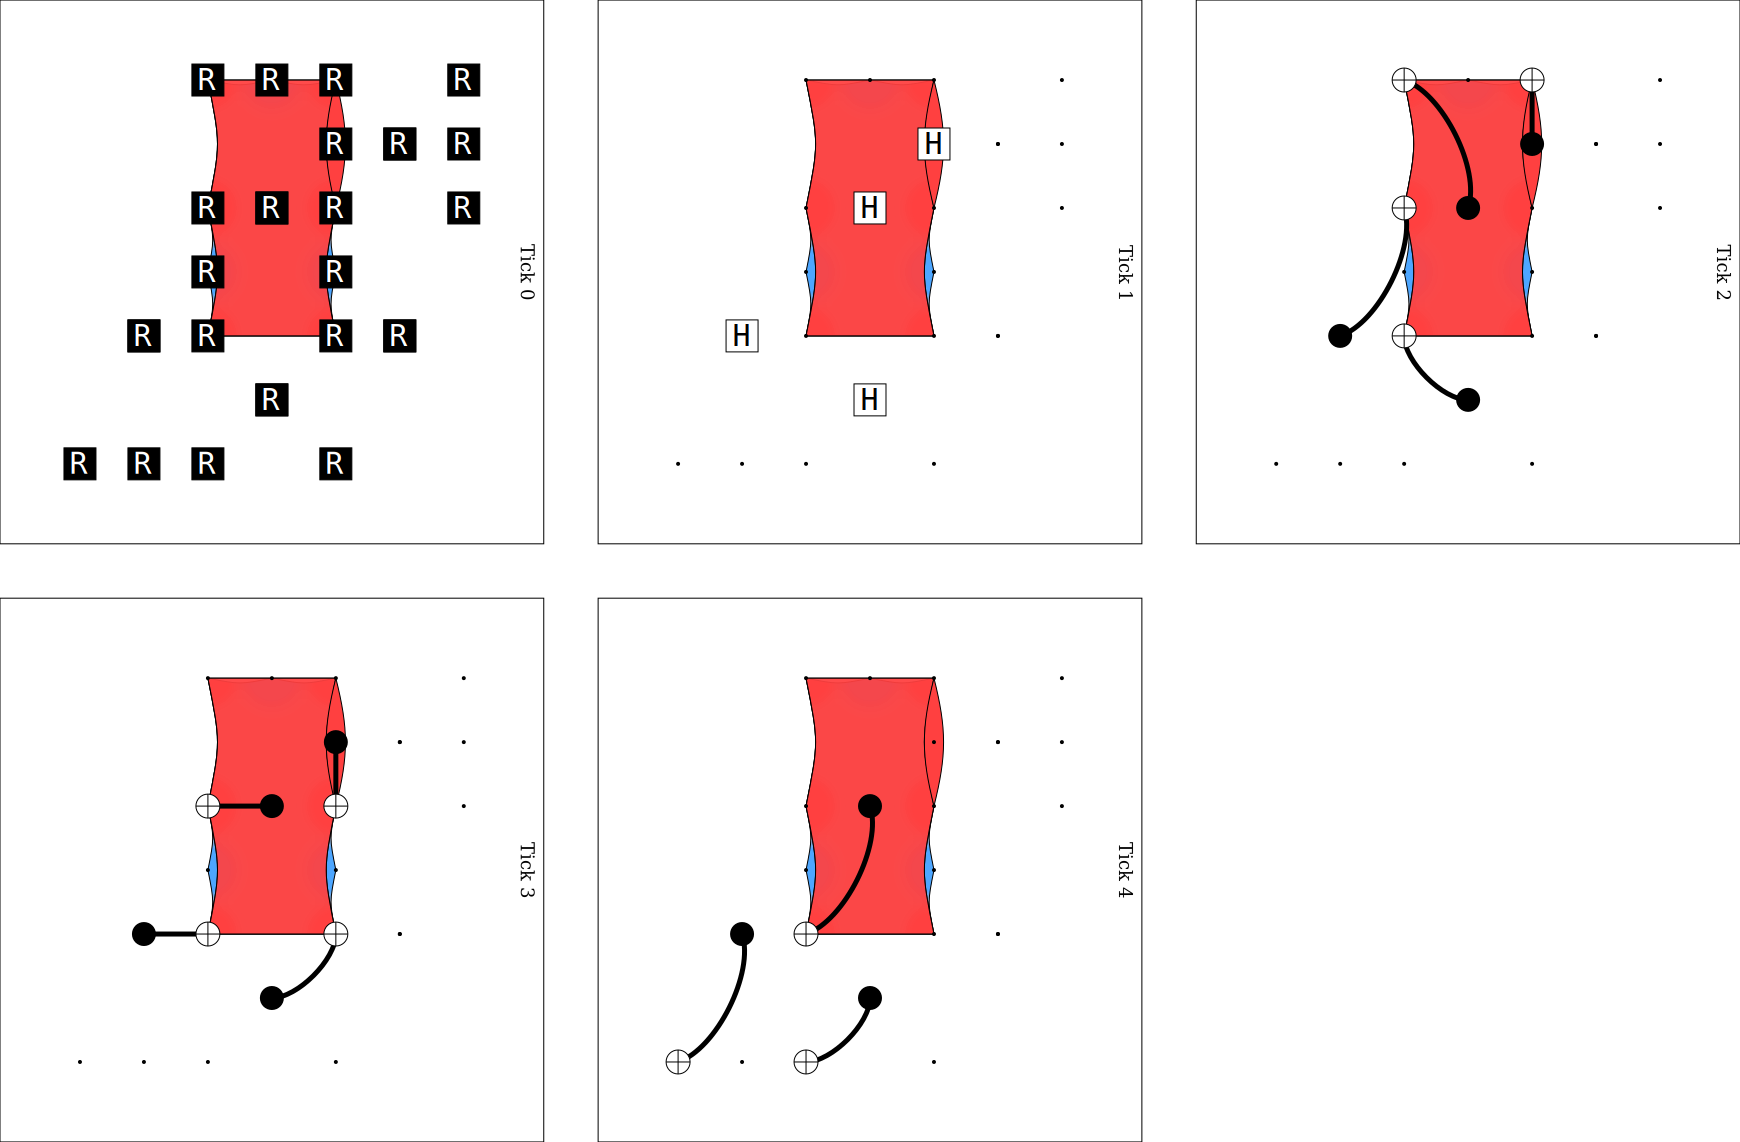

In [ ]:
circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D5', 'D7', 'D13', 'D18'])
